In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Regresión

In [3]:
df=pd.read_csv(r"C:\Users\allan\Documents\Repositories\surrogates-gps\Datasets\Chapter1\wire.csv")

In [4]:
df.head()

pstren   dieh   posth   looph   wlen   diew   postw 
0     8.0    5.2    19.6    29.6   94.9    2.1      2.3
1     8.3    5.2    19.8    32.4   89.7    2.1      1.8
2     8.5    5.8    19.6    31.0   96.2    2.0      2.0
3     8.8    6.4    19.4    32.4   95.6    2.2      2.1
4     9.0    5.8    18.6    28.6   86.5    2.0      1.8

In [5]:
df.columns

Index(['pstren', ' dieh', ' posth', ' looph', ' wlen', ' diew', ' postw '], dtype='object')

In [6]:
x_train=df[[' dieh', ' posth', ' looph', ' wlen', ' diew', ' postw ']].values

In [7]:
y_train=df[['pstren']].values

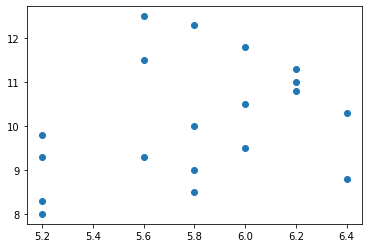

In [8]:
plt.scatter(x_train[:,0],y_train)
plt.show()

In [9]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_scaled = scaler.transform(x_train)

In [10]:
for i in range(len(x_scaled[0,:])):
    x_scaled[:,i]=x_scaled[:,i]/np.max(x_scaled[:,i])

In [11]:
from sklearn.linear_model import LinearRegression #biblioteca de machine learning en Python
from sklearn.preprocessing import PolynomialFeatures

In [12]:
#Transformación de la entrada al grado del polinomio de interés
grado = 2 #3
x_pol = PolynomialFeatures(degree=grado, include_bias=False).fit_transform(x_scaled)
#print(x_pol) #nueva entrada

#Ajuste de la regresión polinomial
rpol = LinearRegression().fit(x_pol, y_train)

In [13]:
#Desempeño de la regresión polinomial
rScore = rpol.score(x_pol, y_train)
print('Coeficiente de determinación:', rScore)

Coeficiente de determinación: 1.0


In [14]:
x_pred=scaler.transform(np.array([6,20,30,90,2,2]).reshape((1,-1)))
for i in range(len(x_pred[0,:])):
    x_pred[:,i]=x_pred[:,i]/np.max(x_scaled[:,i])
x_pred=PolynomialFeatures(degree=grado, include_bias=False).fit_transform(x_pred)

In [15]:
rpol.predict(x_pred)

array([[13.82420784]])

# _Surrogates for Sensitivity_

In [16]:
def A(x):
    return x[4]*x[1]+19.62*x[0]-x[3]*x[2]/x[1]

In [17]:
def V(x):
    return x[1]*(np.sqrt(A(x)**2+4*x[3]*x[4]*x[2]/x[6]*x[5])-A(x))

In [18]:
def C(x):
    x[0]=x[0]*(60-30)+30
    x[1]=x[1]*(0.020-0.005)+0.005
    x[2]=x[2]*(0.010-0.002)+0.002
    x[3]=x[3]*(5000-1000)+1000
    x[4]=x[4]*(1.1e5-0.9e5)+0.9e5
    x[5]=x[5]*(296-290)+290
    x[6]=x[6]*(3600-340)+340
    return 2*np.pi*np.sqrt(x[0]/(x[3]+x[1]**2*x[4]*x[2]/x[6]*x[5]/V(x)**2))

In [19]:
x_baseline=np.zeros(shape=(7,1))

In [20]:
x_baseline[0]=(45-30)/(60-30)
x_baseline[1]=(0.0125-0.005)/(0.020-0.005)
x_baseline[2]=(0.006-0.002)/(0.010-0.002)
x_baseline[3]=(3e3-1e3)/(5e3-1e3)
x_baseline[4]=(1e5-0.9e5)/(1.1e5-0.9e5)
x_baseline[5]=(293-290)/(296-290)
x_baseline[6]=(350-340)/(3600-340)

In [21]:
C(x_baseline.copy())

array([0.76952988])

In [22]:
h=1e-2
x=np.arange(0,1+h,h)

In [23]:
M,k=np.meshgrid(x,x)

In [24]:
c=np.zeros_like(M)
for i in range(len(x)):
    x_baseline[0]=x[i]
    for j in range(len(x)):
        x_baseline[3]=x[j]
        
        c[i,j]=C(x_baseline.copy())

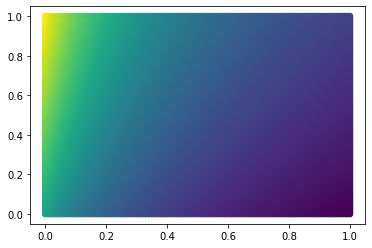

In [25]:
plt.scatter(M,k,c=c)
plt.show()

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [27]:
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 70.0), nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

In [28]:
X_train=np.append(x.copy().reshape(len(x),1),x.copy().reshape(len(x),1),axis=1)

In [29]:
gpr.fit(X_train,c[0,:])

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5),
                         random_state=0)

In [30]:
y_mean, y_std = gpr.predict(X_train, return_std=True)

In [31]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, 100)
    X = np.append(x.copy().reshape(len(x),1),x.copy().reshape(len(x),1),axis=1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim([-3, 3])

Text(0.5, 1.0, 'Samples from posterior distribution')

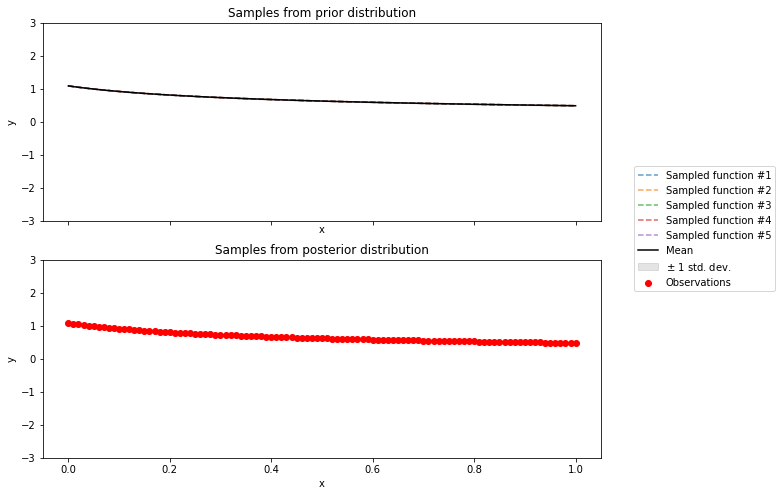

In [32]:
ig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# plot prior
plot_gpr_samples(gpr, n_samples=5, ax=axs[0])
axs[0].set_title("Samples from prior distribution")

# plot posterior
plot_gpr_samples(gpr, n_samples=5, ax=axs[1])
axs[1].scatter(X_train[:, 1], c[0,:], color="red", zorder=10, label="Observations")
axs[1].legend(bbox_to_anchor=(1.05, 1.5), loc="upper left")
axs[1].set_title("Samples from posterior distribution")

# Optimización

In [33]:
def a(x):
    return (4*x[0]+4*x[1]-3)**2*(75-56*(x[0]+x[1])+3*(4*x[0]-2)**2+6*(4*x[0]-2)*(4*x[1]-2)+3*(4*x[1]-2)**2)
def b(x):
    return (8*x[0]-12*x[1]+2)**2*(-14-128*x[0]+12*(4*x[0]-2)**2+192*x[1]-36*(4*x[0]-2)*(4*x[1]-2)+27*(4*x[1]-2)**2)
def c(x):
    return 3/2-x[0]-2*x[1]-np.sin(np.pi*(x[0]**2-2*x[1]))

In [34]:
def f(x):
    return (np.log10((1+a(x))*(30+b(x)))-8.69)/2.43

In [35]:
x=np.arange(-10,10.01,0.01)
X1,X2=np.meshgrid(x,x)

In [36]:
c_value=np.zeros_like(X1)
fun=np.zeros_like(X1)
value=np.array([0,0])
for i in range(len(x)):
    value[0]=x[i]
    for j in range(len(x)):
        value[1]=x[j]
        c_value[i,j]=c(value)
        fun[i,j]=f(value)

C:\Users\allan\AppData\Local\Temp/ipykernel_11840/3906525197.py:2: RuntimeWarning: overflow encountered in long_scalars
  return (np.log10((1+a(x))*(30+b(x)))-8.69)/2.43
C:\Users\allan\AppData\Local\Temp/ipykernel_11840/3906525197.py:2: RuntimeWarning: invalid value encountered in log10
  return (np.log10((1+a(x))*(30+b(x)))-8.69)/2.43
C:\Users\allan\AppData\Local\Temp/ipykernel_11840/610589417.py:4: RuntimeWarning: overflow encountered in long_scalars
  return (8*x[0]-12*x[1]+2)**2*(-14-128*x[0]+12*(4*x[0]-2)**2+192*x[1]-36*(4*x[0]-2)*(4*x[1]-2)+27*(4*x[1]-2)**2)


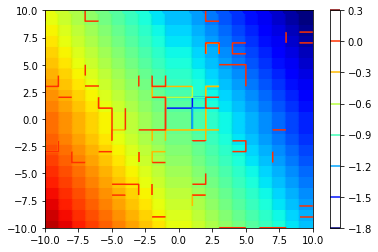

In [37]:
plt.scatter(X1,X2,c=c_value,cmap="jet")
plt.contour(X1,X2,fun,cmap="jet")
plt.colorbar()
plt.show()

In [38]:
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

In [39]:
minimize(f,x0=np.array([0,0]))

      fun: -3.3797854918847454
 hess_inv: array([[0.0023364 , 0.00059712],
       [0.00059712, 0.00139993]])
      jac: array([ 4.47034836e-07, -7.30156898e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 9
     njev: 20
   status: 0
  success: True
        x: array([0.49999998, 0.24999998])

In [40]:
def constraint1(x):
    return -c(x)

In [41]:
def constraint2(x):
    if 0<=x[0]<=1 and 0<=x[1]<=1:
        z=0
    else:
        z=-1
    return z

In [42]:
minimize(f,x0=np.array([10,10]),constraints=[{'type':'ineq','fun':constraint1},{'type':'ineq','fun':constraint2}])

     fun: -2.7838963102947285
     jac: array([ 0.13494903, -0.07202077])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([0.95807817, 0.55518478])

In [43]:
c(np.array([0.95807817, 0.55518478]))

-1.6654402434923554e-07